In [10]:
# Required imports
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 

from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Fetch the dataset
online_retail = fetch_ucirepo(id=352)

# Create full dataframe
X = pd.concat([online_retail.data.ids, online_retail.data.features], axis=1)
X.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [11]:
# Data Preparation and RFM Feature Engineering
# Check for missing values and basic info
print("Dataset Shape:", X.shape)
print("\nMissing Values:\n", X.isnull().sum())
print("\nData Types:\n", X.dtypes)

# Convert InvoiceDate to datetime
X['InvoiceDate'] = pd.to_datetime(X['InvoiceDate'])

# Create RFM features
# Reference date (last date in the dataset + 1 day)
max_date = X['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"\nReference date for RFM analysis: {max_date}")

# Calculate total price
X['TotalPrice'] = X['Quantity'] * X['UnitPrice']

# Group by CustomerID for RFM analysis
rfm = X.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Filter out potential outliers and missing values
rfm = rfm[rfm['Monetary'] > 0]
rfm = rfm.dropna()

print("\nRFM Dataset Shape:", rfm.shape)
print("\nRFM Summary Statistics:")
print(rfm.describe())

# Log transform monetary value to reduce skewness
rfm['Monetary'] = np.log1p(rfm['Monetary'])

# Scale features for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

print("\nScaled RFM Summary Statistics:")
print(rfm_scaled.describe())

Dataset Shape: (541909, 8)

Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Data Types:
 InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Reference date for RFM analysis: 2011-12-10 12:50:00

RFM Dataset Shape: (4322, 3)

RFM Summary Statistics:
           Recency    Frequency      Monetary
count  4322.000000  4322.000000  4.322000e+03
mean     90.343591     5.115687  1.923483e+03
std      99.133565     9.384459  8.263128e+03
min       1.000000     1.000000  1.776357e-15
25%      17.000000     1.000000  3.022925e+02
50%      49.500000     3.000000  6.575500e+02
75%     138.000000     6.000000  1.625740e+03
max     374.000000   248.000000  2.794890e+05

Scaled RFM Summary Statistics:

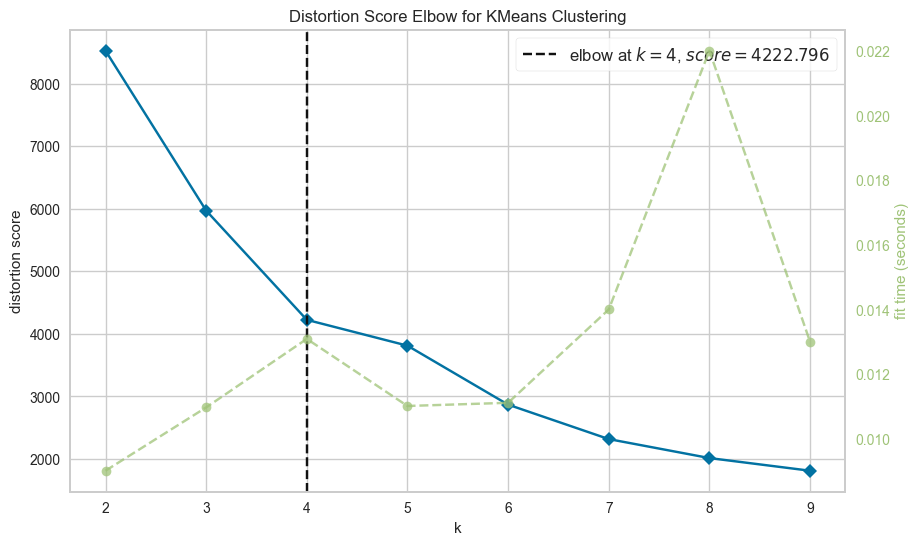

Optimal number of clusters: 4

Cluster Summary:
              Recency Frequency Monetary      
                 mean      mean     mean count
KMeansCluster                                 
0              251.84      1.71     5.62   982
1               30.54      9.72     7.92  1326
2                4.11     74.00    10.35    37
3               51.85      2.43     6.06  1977


C:\Users\User\AppData\Local\Temp\ipykernel_7708\1793593747.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if cluster_summary.loc[cluster, ('Recency', 'mean')] < cluster_summary['Recency'].mean()[0] and \
C:\Users\User\AppData\Local\Temp\ipykernel_7708\1793593747.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_summary.loc[cluster, ('Frequency', 'mean')] > cluster_summary['Frequency'].mean()[0] and \
C:\Users\User\AppData\Local\Temp\ipykernel_7708\1793593747.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

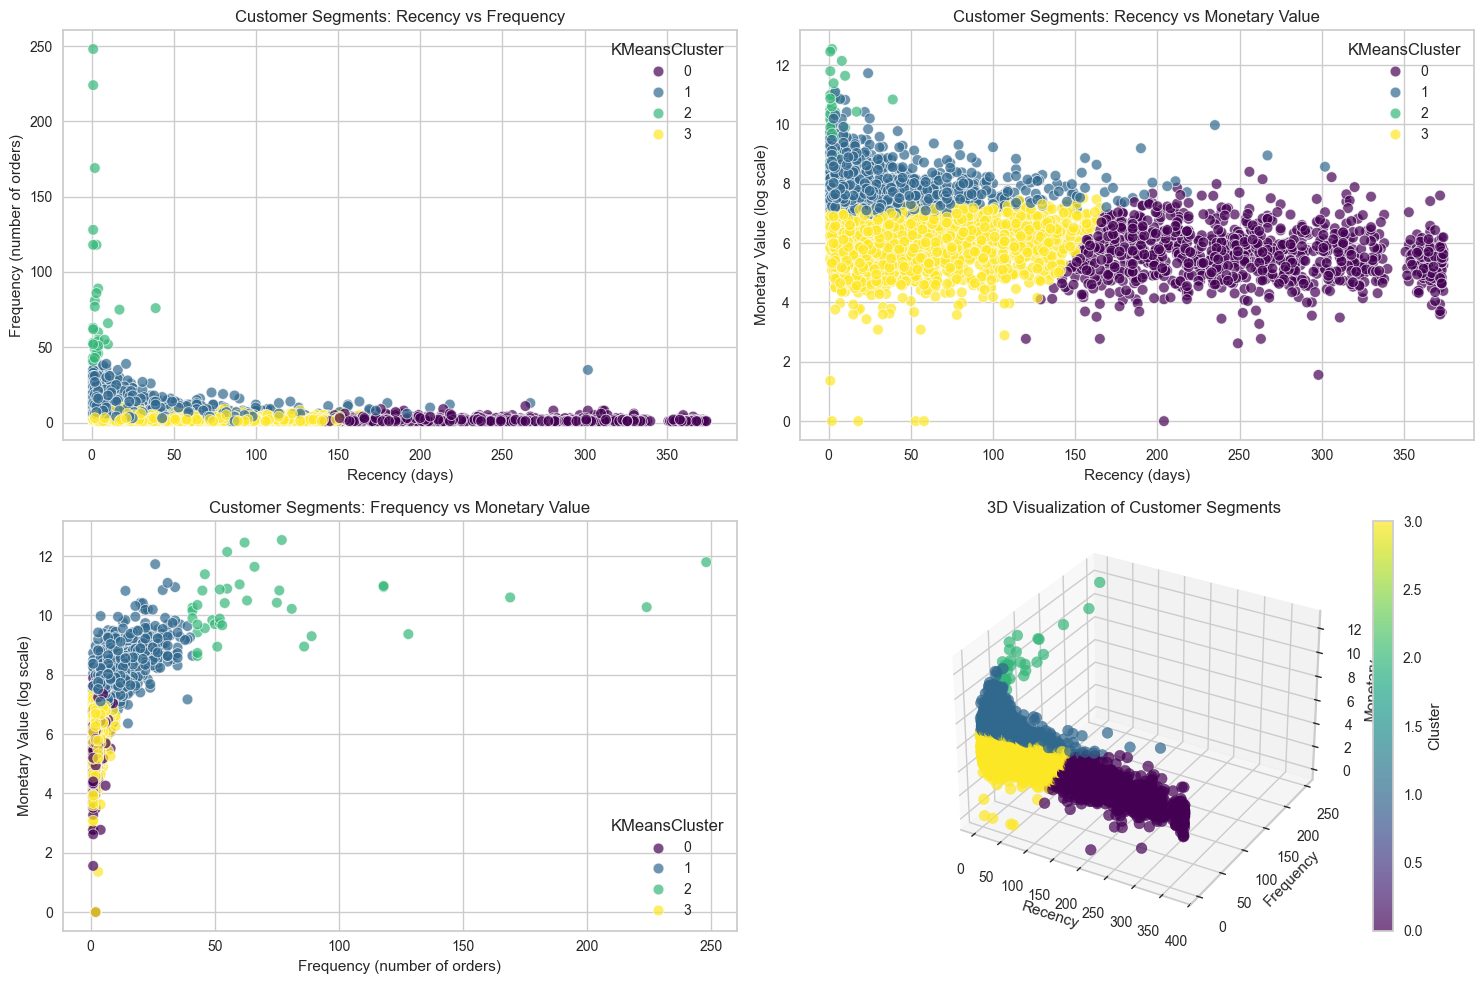

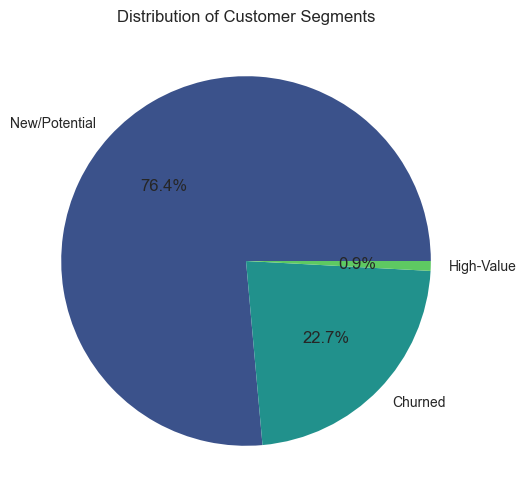

In [12]:
# K-means Clustering on RFM Data
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Find optimal number of clusters using the elbow method
plt.figure(figsize=(10, 6))
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2, 10))
visualizer.fit(rfm_scaled)
visualizer.show()

# Optimal k from elbow method
optimal_k = visualizer.elbow_value_ if visualizer.elbow_value_ else 4
print(f"Optimal number of clusters: {optimal_k}")

# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['KMeansCluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze clusters
cluster_summary = rfm.groupby('KMeansCluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

print("\nCluster Summary:")
print(cluster_summary)

# Create customer segment labels based on RFM values
def create_segment_label(row):
    cluster = row['KMeansCluster']
    if cluster_summary.loc[cluster, ('Recency', 'mean')] < cluster_summary['Recency'].mean()[0] and \
       cluster_summary.loc[cluster, ('Frequency', 'mean')] > cluster_summary['Frequency'].mean()[0] and \
       cluster_summary.loc[cluster, ('Monetary', 'mean')] > cluster_summary['Monetary'].mean()[0]:
        return 'High-Value'
    elif cluster_summary.loc[cluster, ('Recency', 'mean')] > cluster_summary['Recency'].mean()[0] and \
         cluster_summary.loc[cluster, ('Frequency', 'mean')] < cluster_summary['Frequency'].mean()[0]:
        return 'Churned'
    elif cluster_summary.loc[cluster, ('Recency', 'mean')] < cluster_summary['Recency'].mean()[0] and \
         cluster_summary.loc[cluster, ('Frequency', 'mean')] < cluster_summary['Frequency'].mean()[0]:
        return 'New/Potential'
    else:
        return 'Regular'

rfm['CustomerSegment'] = rfm.apply(create_segment_label, axis=1)

# Visualize clusters with scatter plots
plt.figure(figsize=(15, 10))

# Plot 1: Recency vs Frequency
plt.subplot(2, 2, 1)
sns.scatterplot(x='Recency', y='Frequency', hue='KMeansCluster', data=rfm, palette='viridis', s=60, alpha=0.7)
plt.title('Customer Segments: Recency vs Frequency')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (number of orders)')

# Plot 2: Recency vs Monetary
plt.subplot(2, 2, 2)
sns.scatterplot(x='Recency', y='Monetary', hue='KMeansCluster', data=rfm, palette='viridis', s=60, alpha=0.7)
plt.title('Customer Segments: Recency vs Monetary Value')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value (log scale)')

# Plot 3: Frequency vs Monetary
plt.subplot(2, 2, 3)
sns.scatterplot(x='Frequency', y='Monetary', hue='KMeansCluster', data=rfm, palette='viridis', s=60, alpha=0.7)
plt.title('Customer Segments: Frequency vs Monetary Value')
plt.xlabel('Frequency (number of orders)')
plt.ylabel('Monetary Value (log scale)')

# Plot 4: 3D visualization using segment labels
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(2, 2, 4, projection='3d')
scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], 
                    c=rfm['KMeansCluster'], cmap='viridis', s=60, alpha=0.7)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Visualization of Customer Segments')
plt.colorbar(scatter, label='Cluster')

plt.tight_layout()
plt.show()

# Distribution of customer segments
plt.figure(figsize=(10, 6))
segment_counts = rfm['CustomerSegment'].value_counts()
segment_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('viridis', len(segment_counts)))
plt.title('Distribution of Customer Segments')
plt.ylabel('')
plt.show()

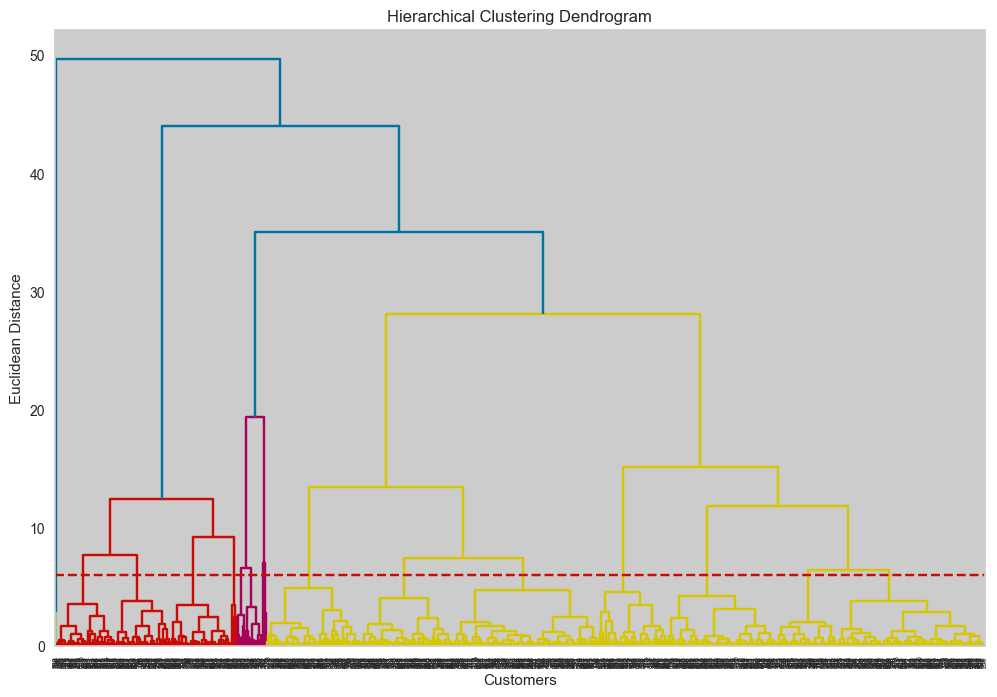


Hierarchical Cluster Summary:
                    Recency Frequency Monetary      
                       mean      mean     mean count
HierarchicalCluster                                 
0                    229.35      1.97     5.76  1212
1                     11.45     24.43     8.91   291
2                     43.04      2.05     5.81  1391
3                      1.50    167.50    10.67     6
4                     34.65      6.15     7.49  1422


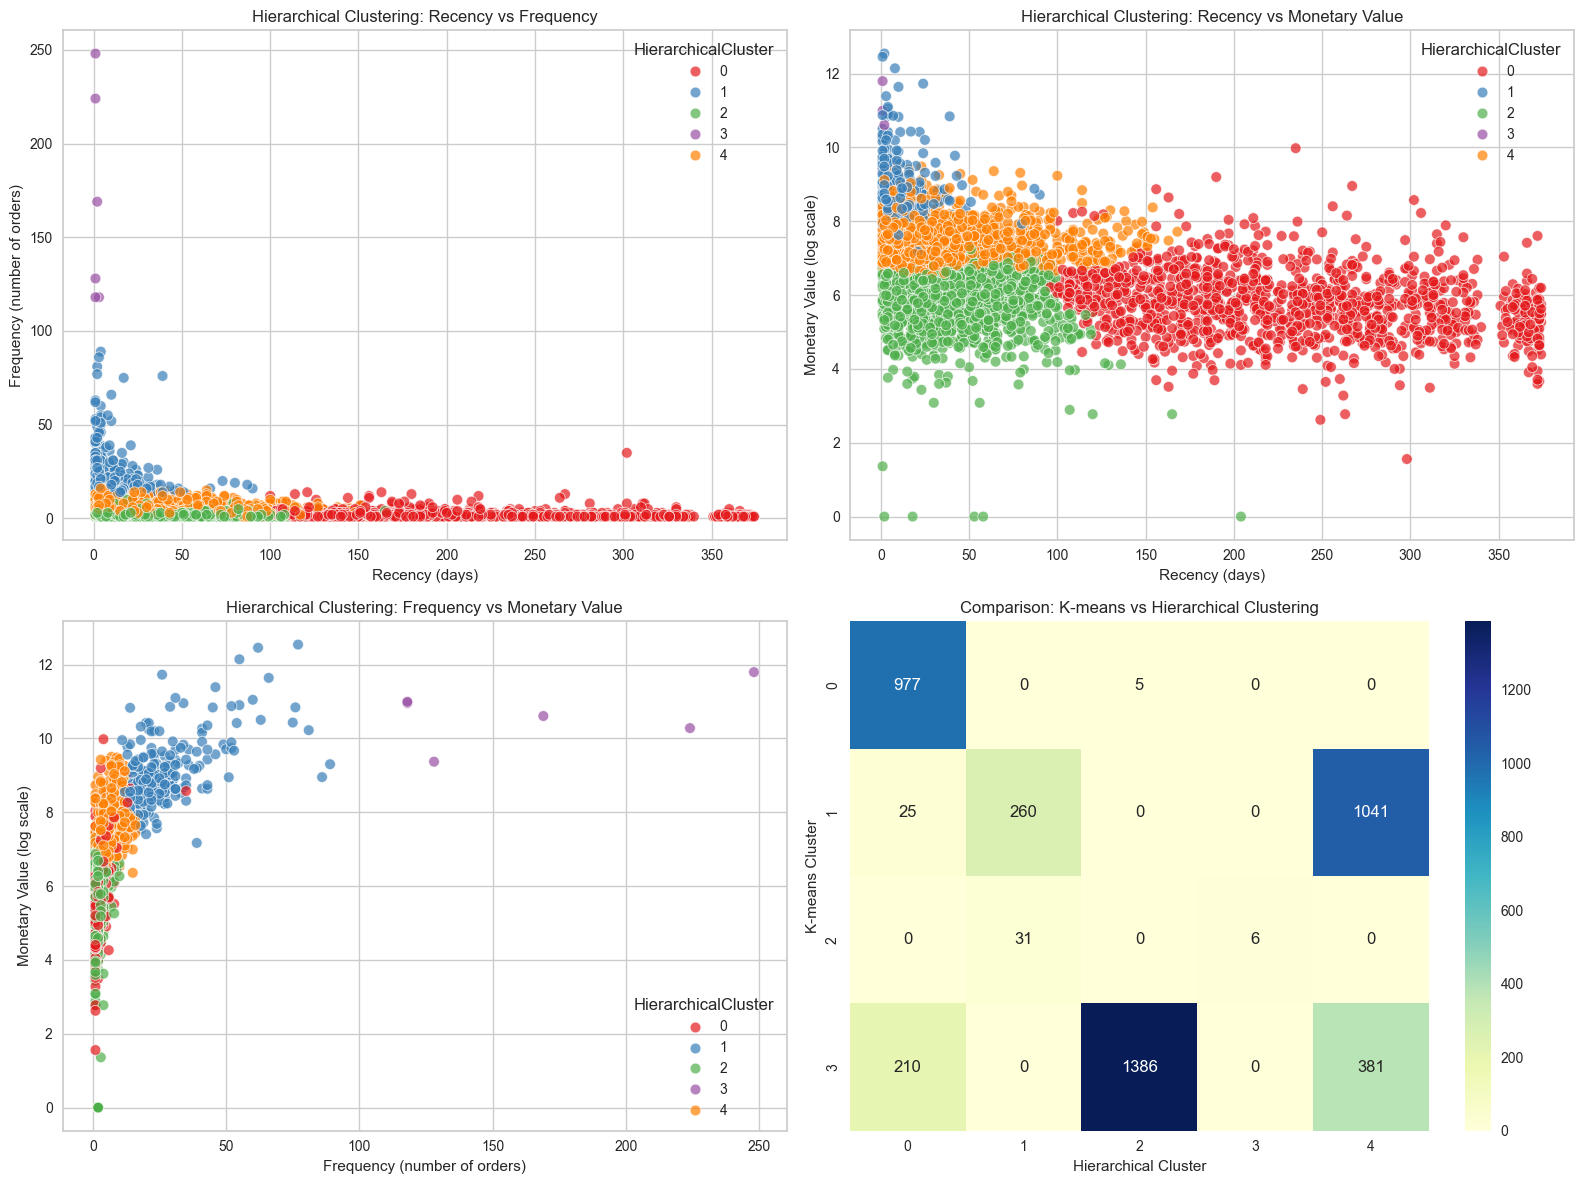

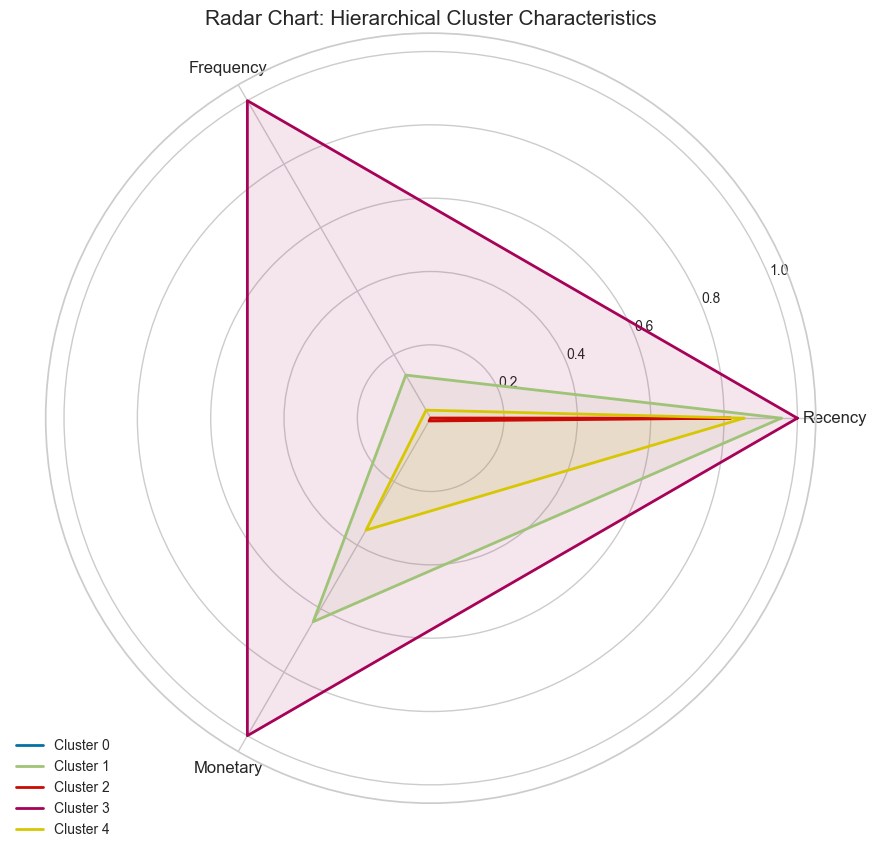

In [13]:
# Cell 3: Hierarchical Clustering Analysis
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# Sample data if the dataset is too large (for visualization purposes)
sample_size = 1000 if len(rfm_scaled) > 1000 else len(rfm_scaled)
rfm_sample = rfm_scaled.sample(sample_size, random_state=42)

# Plot dendrogram to visualize hierarchical clustering structure
plt.figure(figsize=(12, 8))
dendrogram = shc.dendrogram(shc.linkage(rfm_sample, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.axhline(y=6, color='r', linestyle='--')  # Line to suggest a potential cut for number of clusters
plt.show()

# Determine number of clusters from dendrogram (4-5 is common for RFM analysis)
n_clusters = 5

# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
rfm['HierarchicalCluster'] = hierarchical.fit_predict(rfm_scaled)

# Analyze hierarchical clusters
h_cluster_summary = rfm.groupby('HierarchicalCluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

print("\nHierarchical Cluster Summary:")
print(h_cluster_summary)

# Visualize hierarchical clusters with scatter plots
plt.figure(figsize=(16, 12))

# Plot 1: Recency vs Frequency
plt.subplot(2, 2, 1)
sns.scatterplot(x='Recency', y='Frequency', hue='HierarchicalCluster', data=rfm, palette='Set1', s=60, alpha=0.7)
plt.title('Hierarchical Clustering: Recency vs Frequency')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (number of orders)')

# Plot 2: Recency vs Monetary
plt.subplot(2, 2, 2)
sns.scatterplot(x='Recency', y='Monetary', hue='HierarchicalCluster', data=rfm, palette='Set1', s=60, alpha=0.7)
plt.title('Hierarchical Clustering: Recency vs Monetary Value')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value (log scale)')

# Plot 3: Frequency vs Monetary
plt.subplot(2, 2, 3)
sns.scatterplot(x='Frequency', y='Monetary', hue='HierarchicalCluster', data=rfm, palette='Set1', s=60, alpha=0.7)
plt.title('Hierarchical Clustering: Frequency vs Monetary Value')
plt.xlabel('Frequency (number of orders)')
plt.ylabel('Monetary Value (log scale)')

# Plot 4: Comparison of K-means and Hierarchical clustering
plt.subplot(2, 2, 4)
# Create a contingency table to compare clustering methods
contingency_table = pd.crosstab(rfm['KMeansCluster'], rfm['HierarchicalCluster'])
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d', cbar=True)
plt.title('Comparison: K-means vs Hierarchical Clustering')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('K-means Cluster')

plt.tight_layout()
plt.show()

# Radar chart for comparing cluster characteristics
from math import pi

# Prepare data for radar chart
cluster_means = rfm.groupby('HierarchicalCluster')[['Recency', 'Frequency', 'Monetary']].mean()
cluster_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())  # Normalize

# Recency should be inversed (lower is better)
cluster_means['Recency'] = 1 - cluster_means['Recency']

# Number of variables
categories = list(cluster_means.columns)
N = len(categories)

# Create angles for radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create radar chart
plt.figure(figsize=(12, 10))
ax = plt.subplot(111, polar=True)

# Add labels
plt.xticks(angles[:-1], categories, size=12)

# Draw cluster lines
for cluster in cluster_means.index:
    values = cluster_means.loc[cluster].values.flatten().tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Radar Chart: Hierarchical Cluster Characteristics', size=15)
plt.show()

Selected epsilon value: 0.2513
Number of clusters found by DBSCAN: 2
Number of noise points: 171 (3.96%)

DBSCAN Cluster Summary (excluding noise):
              Recency Frequency Monetary      
                 mean      mean     mean count
DBSCANCluster                                 
0               90.26      4.28      6.5  4151


c:\Users\User\x-med\.conda\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_7708\201684223.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(x='TSNE1', y='TSNE2', hue='DBSCANCluster',
C:\Users\User\AppData\Local\Temp\ipykernel_7708\201684223.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')
C:\Users\User\AppData\Local\Temp\ipykernel_7708\201684223.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='TSNE1', y='TSNE2', hue='KMeansCluster',
C:\Users\User\AppData\Local\Temp\ipykernel_7708\201684223.py:89: UserWarning: Ignoring `palette` because no `hue` variable has been assi

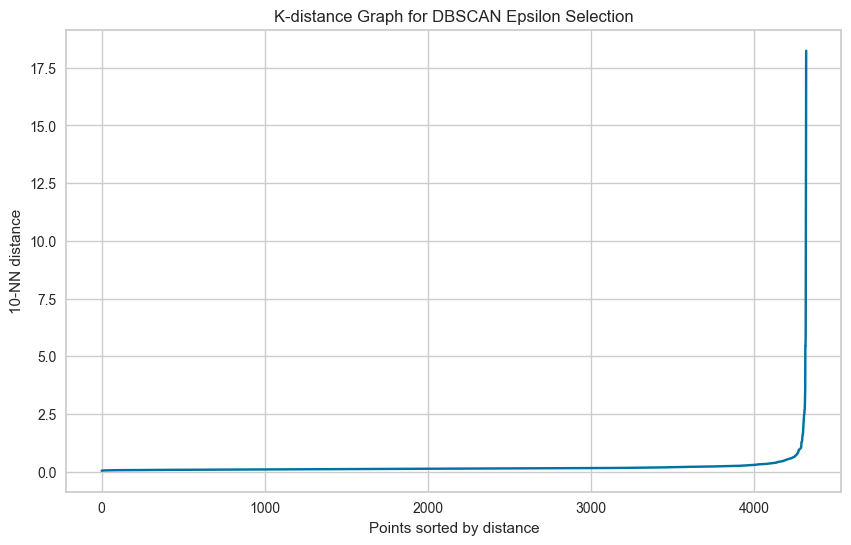

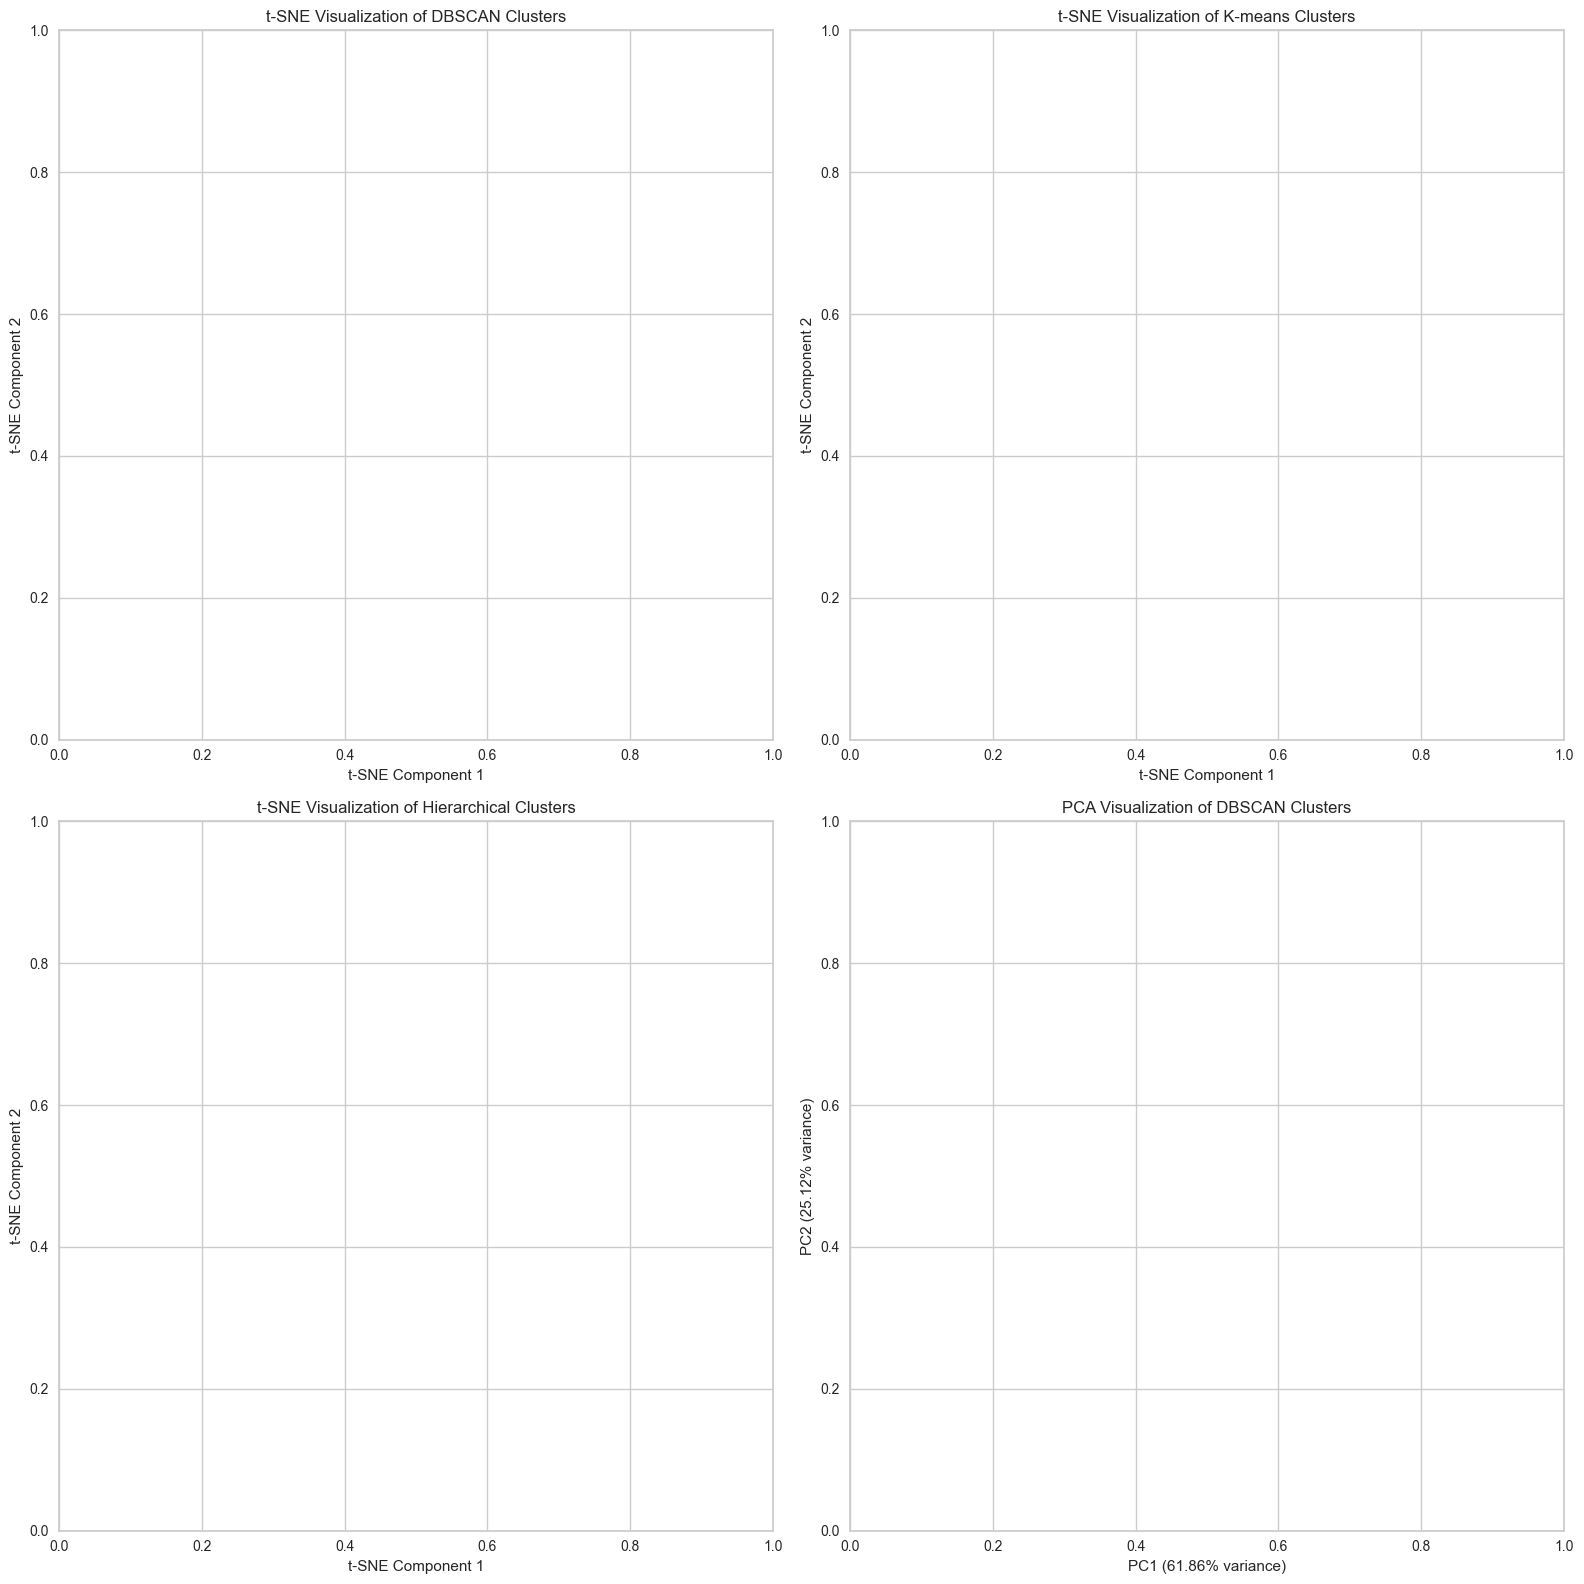

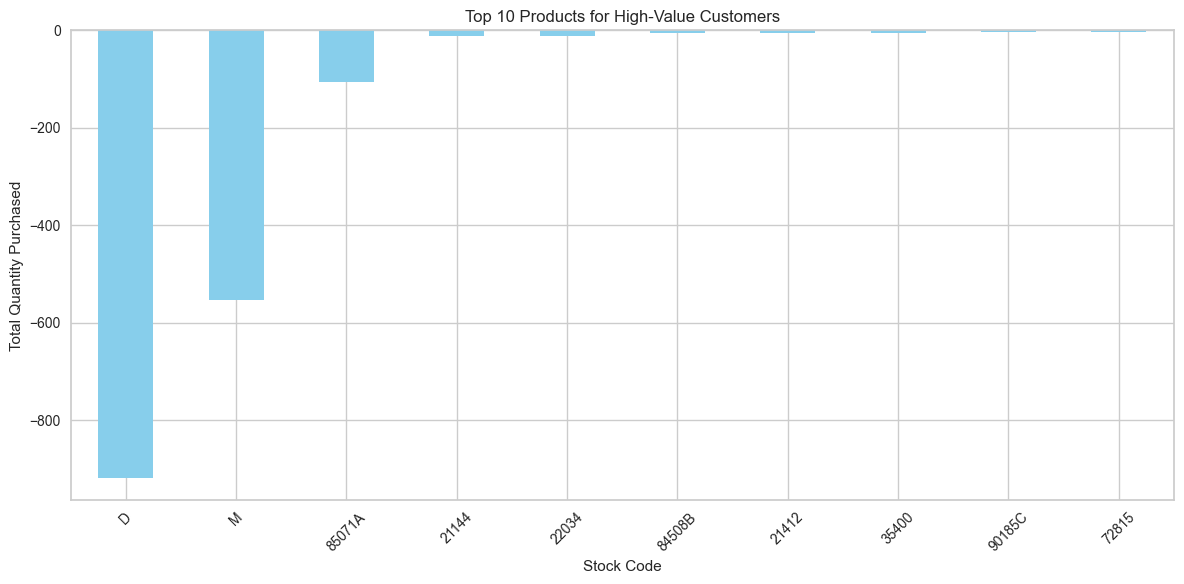

In [14]:
# DBSCAN Clustering and Product Analysis
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# DBSCAN clustering
# Determine epsilon (eps) using k-distance graph
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

# Sort distances for k-distance graph
distances = np.sort(distances, axis=0)
distances = distances[:,9]  # k=10, so index 9

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('10-NN distance')
plt.title('K-distance Graph for DBSCAN Epsilon Selection')
plt.grid(True)

# Find elbow point for eps (you might need to identify this visually)
# From the graph, estimate a good eps value - typically at the "elbow"
eps_value = np.percentile(distances, 90)  # We can use 90th percentile as an automatic selection
print(f"Selected epsilon value: {eps_value:.4f}")

# Apply DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=5)
rfm['DBSCANCluster'] = dbscan.fit_predict(rfm_scaled)

# Report on number of clusters and noise points
n_clusters = len(set(rfm['DBSCANCluster'])) - (1 if -1 in rfm['DBSCANCluster'] else 0)
n_noise = list(rfm['DBSCANCluster']).count(-1)

print(f"Number of clusters found by DBSCAN: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(rfm)*100:.2f}%)")

# Analyze DBSCAN clusters
dbscan_cluster_summary = rfm[rfm['DBSCANCluster'] != -1].groupby('DBSCANCluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

print("\nDBSCAN Cluster Summary (excluding noise):")
print(dbscan_cluster_summary)

# Visualize DBSCAN results using t-SNE for dimensionality reduction
# t-SNE to visualize high-dimensional data
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
rfm_tsne = tsne.fit_transform(rfm_scaled)

# Create dataframe with t-SNE results
tsne_df = pd.DataFrame(data=rfm_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['DBSCANCluster'] = rfm['DBSCANCluster']
tsne_df['KMeansCluster'] = rfm['KMeansCluster']
tsne_df['HierarchicalCluster'] = rfm['HierarchicalCluster']

# Plot DBSCAN clusters with t-SNE
plt.figure(figsize=(16, 16))

# Plot 1: DBSCAN clusters
plt.subplot(2, 2, 1)
scatter = sns.scatterplot(x='TSNE1', y='TSNE2', hue='DBSCANCluster', 
                         data=tsne_df, palette='viridis', s=70, alpha=0.7)
plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# Adjust legend for better visibility
if n_clusters > 10:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend(loc='best')

# Plot 2: t-SNE visualization of K-means
plt.subplot(2, 2, 2)
sns.scatterplot(x='TSNE1', y='TSNE2', hue='KMeansCluster', 
               data=tsne_df, palette='Set1', s=70, alpha=0.7)
plt.title('t-SNE Visualization of K-means Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Plot 3: t-SNE visualization of Hierarchical Clustering
plt.subplot(2, 2, 3)
sns.scatterplot(x='TSNE1', y='TSNE2', hue='HierarchicalCluster', 
               data=tsne_df, palette='Set2', s=70, alpha=0.7)
plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Plot 4: PCA visualization for comparison
# Apply PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
pca_df = pd.DataFrame(data=rfm_pca, columns=['PC1', 'PC2'])
pca_df['DBSCANCluster'] = rfm['DBSCANCluster']

plt.subplot(2, 2, 4)
sns.scatterplot(x='PC1', y='PC2', hue='DBSCANCluster', 
               data=pca_df, palette='viridis', s=70, alpha=0.7)
plt.title('PCA Visualization of DBSCAN Clusters')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

plt.tight_layout()
plt.show()

# Bonus: Product Association Analysis (using the original dataset)
# Create a basket analysis for one of the identified customer segments
# Let's pick the high-value segment from K-means
high_value_customers = rfm[rfm['CustomerSegment'] == 'High-Value'].index

# Filter transactions for high-value customers
high_value_transactions = X[X['CustomerID'].isin(high_value_customers)]

# Top products for high-value customers
top_products = high_value_transactions.groupby('StockCode')['Quantity'].sum().sort_values().head(10)

plt.figure(figsize=(12, 6))
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Products for High-Value Customers')
plt.xlabel('Stock Code')
plt.ylabel('Total Quantity Purchased')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Components: 2, BIC: 22915.20, AIC: 22794.14, Silhouette: 0.342
Components: 3, BIC: 20081.98, AIC: 19897.20, Silhouette: 0.375
Components: 4, BIC: 18218.13, AIC: 17969.64, Silhouette: 0.232
Components: 5, BIC: 17342.47, AIC: 17030.26, Silhouette: 0.259
Components: 6, BIC: 16794.71, AIC: 16418.79, Silhouette: 0.217
Components: 7, BIC: 2217.20, AIC: 1777.57, Silhouette: 0.054
Components: 8, BIC: 16415.93, AIC: 15912.59, Silhouette: 0.165
Components: 9, BIC: 1668.99, AIC: 1101.93, Silhouette: -0.018


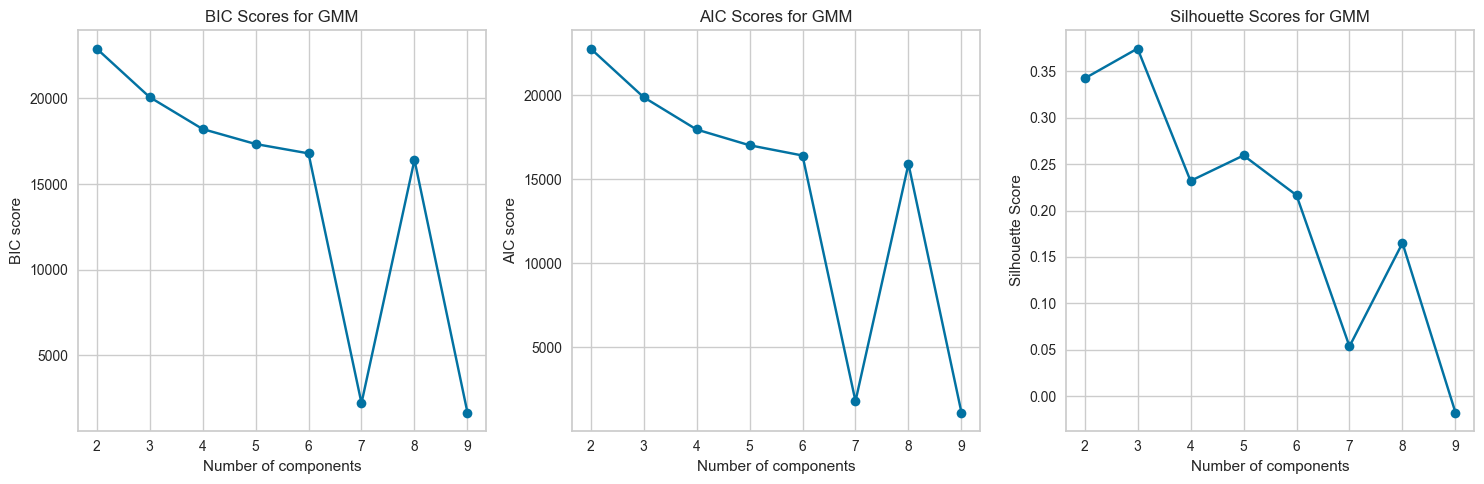

Optimal number of GMM components based on BIC: 9

GMM Cluster Summary:
           Recency Frequency Monetary      
              mean      mean     mean count
GMMCluster                                 
0           154.38      1.00     5.51  1282
1            28.37      4.64     6.98   919
2            11.25     10.87     7.97   583
3            33.28      2.00     6.16   430
4            99.81      9.70     7.57   159
5             2.00    169.00    10.52     5
6           138.29      3.60     6.54   424
7           187.89      2.00     5.89   374
8             5.64     32.22     9.38   146


C:\Users\User\AppData\Local\Temp\ipykernel_7708\1308108779.py:91: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PC1', y='PC2', hue='GMMCluster', data=pca_df,
C:\Users\User\AppData\Local\Temp\ipykernel_7708\1308108779.py:99: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PC1', y='PC2', hue='KMeansCluster', data=pca_df,
C:\Users\User\AppData\Local\Temp\ipykernel_7708\1308108779.py:107: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PC1', y='PC2', hue='HierarchicalCluster', data=pca_df,
C:\Users\User\AppData\Local\Temp\ipykernel_7708\1308108779.py:115: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PC1', y='PC2', hue='DBSCANCluster', data=pca_df,


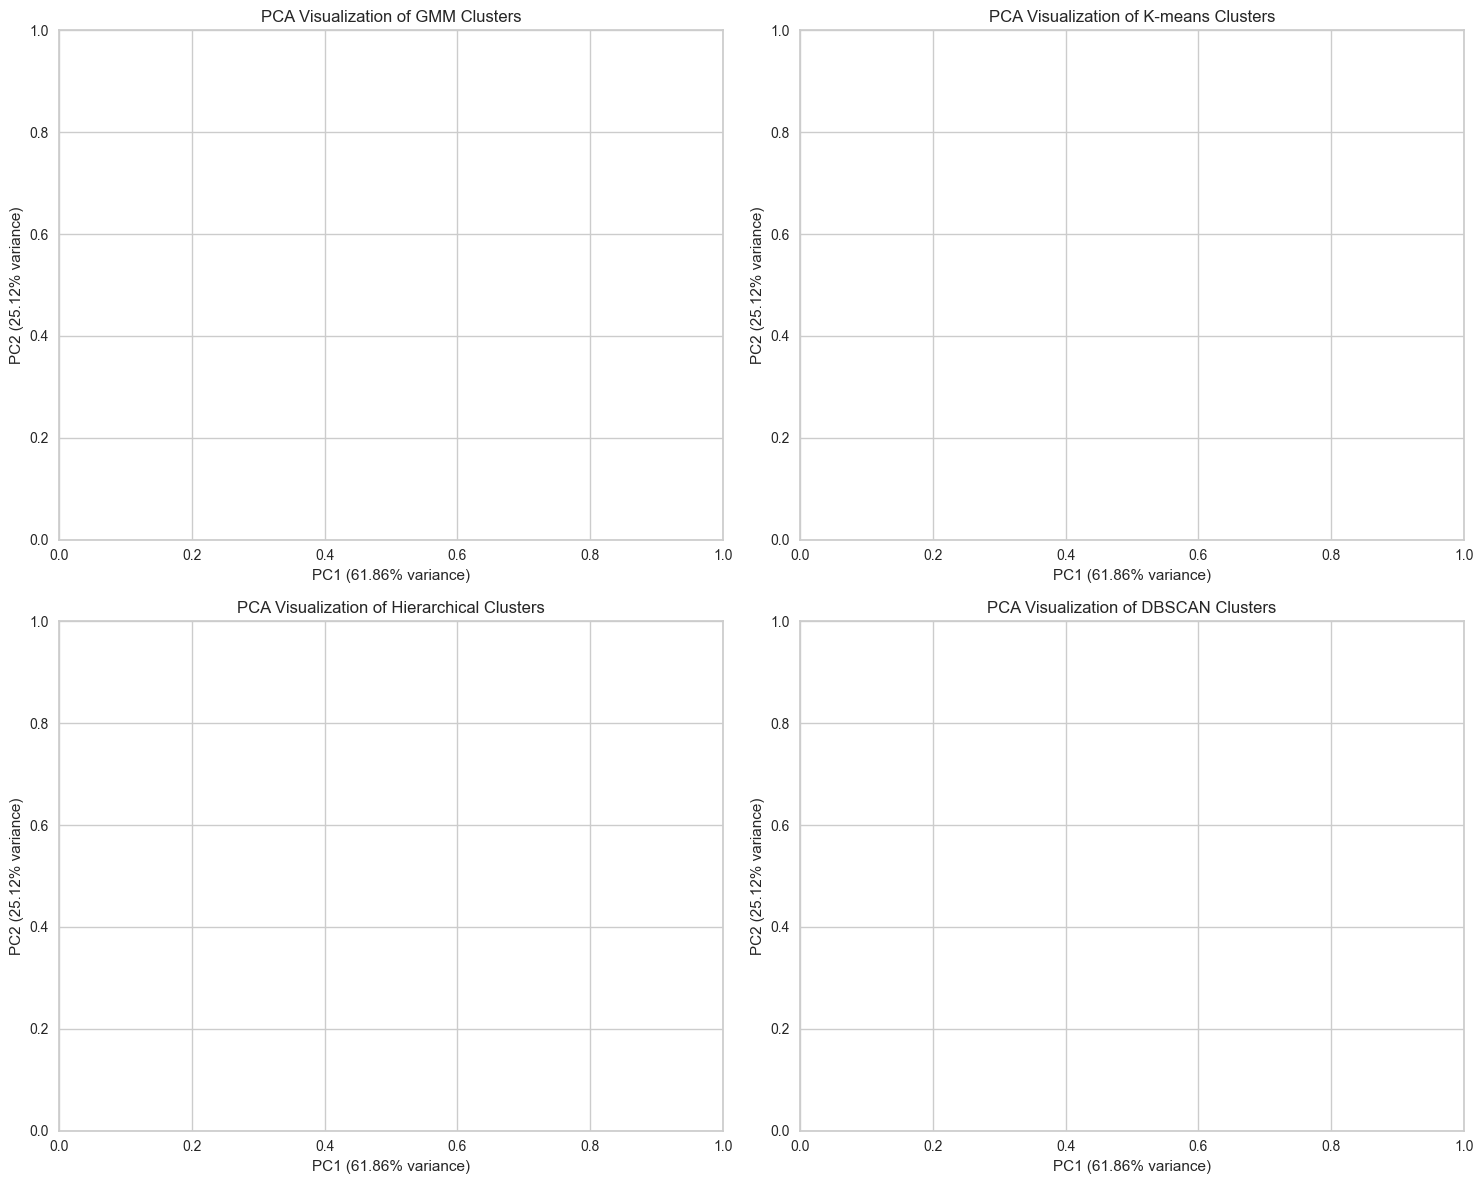

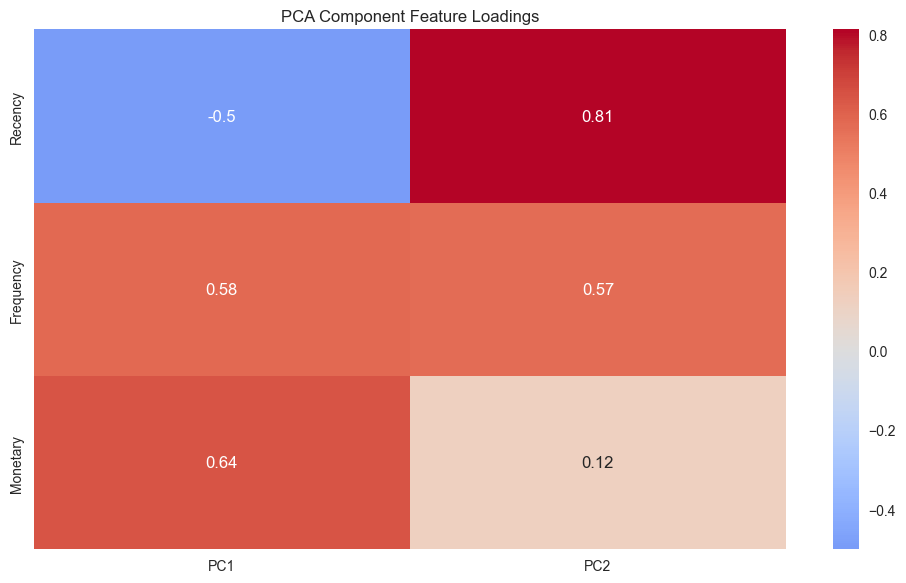

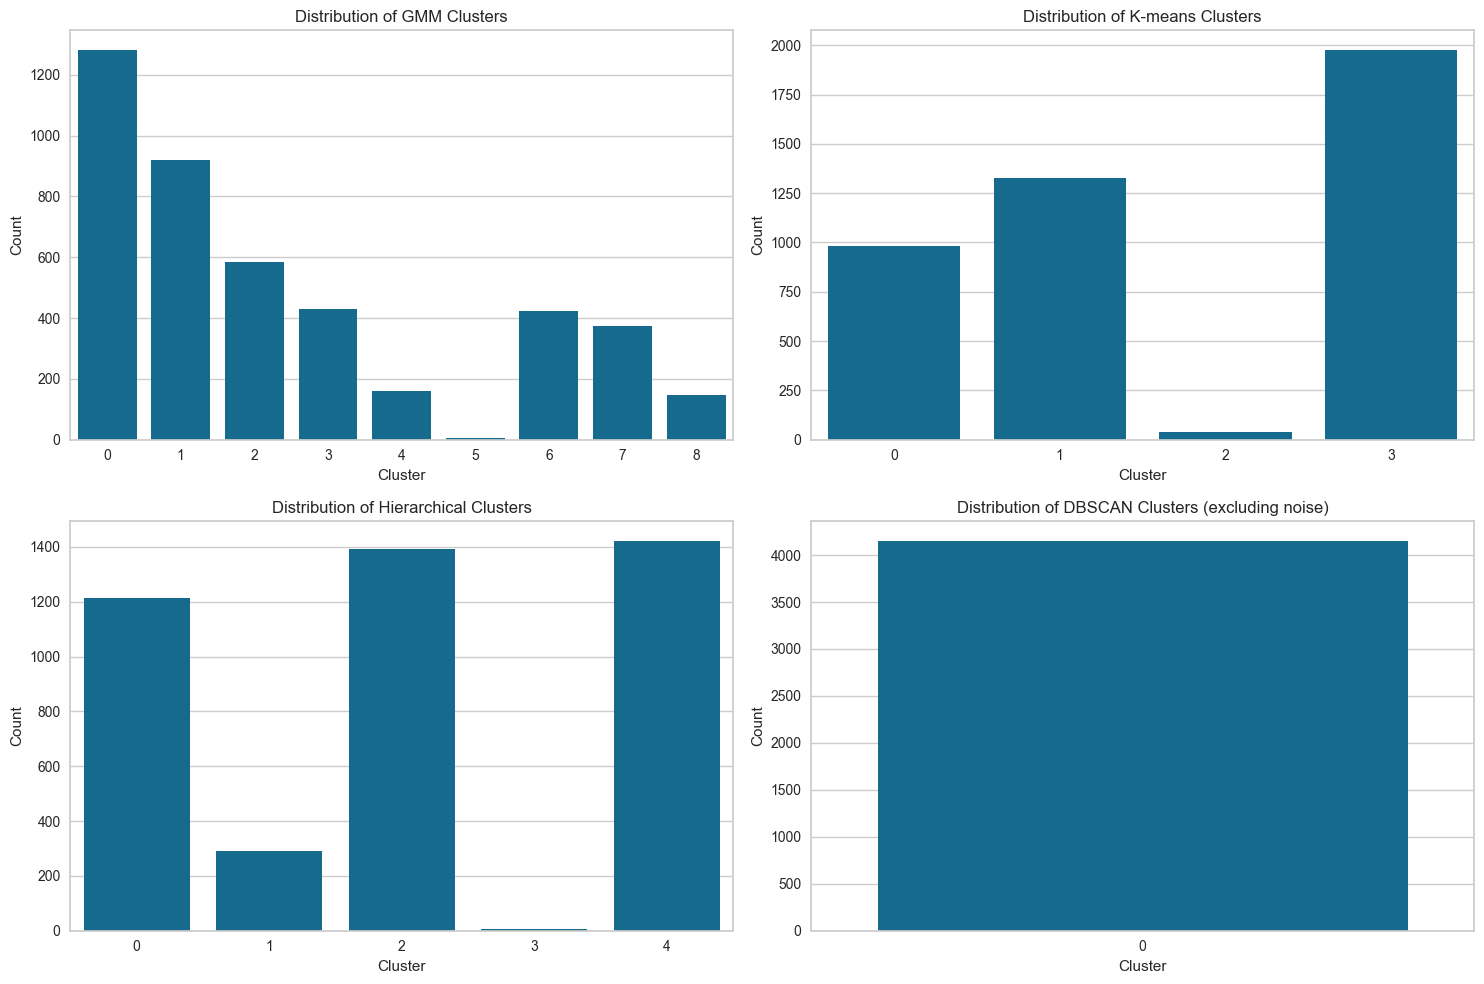

In [15]:
# Cell 5: Gaussian Mixture Models (GMM) Clustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Determine optimal number of components using BIC and AIC
n_components_range = range(2, 10)
bic_scores = []
aic_scores = []
silhouette_scores = []

for n_components in n_components_range:
    # Train GMM model
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(rfm_scaled)
    
    # Get predictions
    labels = gmm.predict(rfm_scaled)
    
    # Store BIC and AIC scores
    bic_scores.append(gmm.bic(rfm_scaled))
    aic_scores.append(gmm.aic(rfm_scaled))
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"Components: {n_components}, BIC: {gmm.bic(rfm_scaled):.2f}, AIC: {gmm.aic(rfm_scaled):.2f}, Silhouette: {silhouette_avg:.3f}")

# Plot scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(n_components_range, bic_scores, 'o-')
plt.xlabel('Number of components')
plt.ylabel('BIC score')
plt.title('BIC Scores for GMM')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(n_components_range, aic_scores, 'o-')
plt.xlabel('Number of components')
plt.ylabel('AIC score')
plt.title('AIC Scores for GMM')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(n_components_range, silhouette_scores, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for GMM')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find optimal number of components (minimum BIC usually)
optimal_components = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of GMM components based on BIC: {optimal_components}")

# Apply GMM with optimal components
gmm = GaussianMixture(n_components=optimal_components, random_state=42)
rfm['GMMCluster'] = gmm.fit_predict(rfm_scaled)

# Analyze GMM clusters
gmm_cluster_summary = rfm.groupby('GMMCluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

print("\nGMM Cluster Summary:")
print(gmm_cluster_summary)

# Apply PCA for visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Create dataframe with PCA results
pca_df = pd.DataFrame(data=rfm_pca, columns=['PC1', 'PC2'])
pca_df['GMMCluster'] = rfm['GMMCluster']
pca_df['KMeansCluster'] = rfm['KMeansCluster']
pca_df['HierarchicalCluster'] = rfm['HierarchicalCluster']
pca_df['DBSCANCluster'] = rfm['DBSCANCluster']

# Visualize GMM clusters
plt.figure(figsize=(15, 12))

# Plot 1: GMM clusters
plt.subplot(2, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='GMMCluster', data=pca_df, 
                palette='rainbow', s=70, alpha=0.7)
plt.title('PCA Visualization of GMM Clusters')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Plot 2: Compare with K-means
plt.subplot(2, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='KMeansCluster', data=pca_df,
                palette='viridis', s=70, alpha=0.7)
plt.title('PCA Visualization of K-means Clusters')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Plot 3: Compare with Hierarchical
plt.subplot(2, 2, 3)
sns.scatterplot(x='PC1', y='PC2', hue='HierarchicalCluster', data=pca_df,
                palette='Set1', s=70, alpha=0.7)
plt.title('PCA Visualization of Hierarchical Clusters')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Plot 4: Compare with DBSCAN
plt.subplot(2, 2, 4)
sns.scatterplot(x='PC1', y='PC2', hue='DBSCANCluster', data=pca_df,
                palette='Set2', s=70, alpha=0.7)
plt.title('PCA Visualization of DBSCAN Clusters')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

plt.tight_layout()
plt.show()

# Create feature importance visualization for PCA components
plt.figure(figsize=(10, 6))
features = rfm_scaled.columns
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(2)], 
    index=features
)

# Create a heatmap of feature loadings
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Component Feature Loadings')
plt.tight_layout()
plt.show()

# Compare cluster distributions across methods using a count plot
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='GMMCluster', data=rfm)
plt.title('Distribution of GMM Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
sns.countplot(x='KMeansCluster', data=rfm)
plt.title('Distribution of K-means Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
sns.countplot(x='HierarchicalCluster', data=rfm)
plt.title('Distribution of Hierarchical Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
# For DBSCAN, we'll show only non-noise points
dbscan_no_noise = rfm[rfm['DBSCANCluster'] != -1]
if len(dbscan_no_noise) > 0:
    sns.countplot(x='DBSCANCluster', data=dbscan_no_noise)
    plt.title('Distribution of DBSCAN Clusters (excluding noise)')
else:
    plt.text(0.5, 0.5, 'All points classified as noise', horizontalalignment='center', size=12)
    plt.title('DBSCAN Clustering Result')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.tight_layout()
plt.show()